In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
train_file = '/content/drive/MyDrive/DataHeightWave/Hososhima/HososhimaTraining.csv'
test_file = '/content/drive/MyDrive/DataHeightWave/Hososhima/HososhimaTesting.csv'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)

In [ ]:
from sklearn.preprocessing import StandardScaler
X_train=train.drop('output', axis=1)
y_train=train['output']
X_test=test.drop('output', axis=1)
y_test=test['output']
X_train_original = X_train.copy()
X_test_original =X_test.copy()
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_test.shape, X_train.shape

((190, 15), (381, 15))

In [ ]:
!pip install xgboost==1.7.5
#!pip install scikit-learn==1.0.2
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

<ipython-input-11-3deb4a7b8c0f>:8: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


> threshold=0.007546698674559593, features=15, accuracy=0.902606056138924,nrmse=0.04895757683204508
> threshold=0.009495934471487999, features=14, accuracy=0.9033521704129726,nrmse=0.04876484659628919
> threshold=0.011001198552548885, features=13, accuracy=0.9030126853174727,nrmse=0.04883292537008421
> threshold=0.011049148626625538, features=12, accuracy=0.9067665053951798,nrmse=0.048117029639087434
> threshold=0.012178766541182995, features=11, accuracy=0.8968027912644436,nrmse=0.050211466544275586
> threshold=0.015232257544994354, features=10, accuracy=0.8946523862365817,nrmse=0.050287265547635386
> threshold=0.015567642636597157, features=9, accuracy=0.8999240426428614,nrmse=0.04915523008786273
> threshold=0.015605911612510681, features=8, accuracy=0.9016136815213245,nrmse=0.04879566272745993
> threshold=0.015986450016498566, features=7, accuracy=0.8971926720318943,nrmse=0.04972297646813007
> threshold=0.016693608835339546, features=6, accuracy=0.8949250794525035,nrmse=0.0499257217

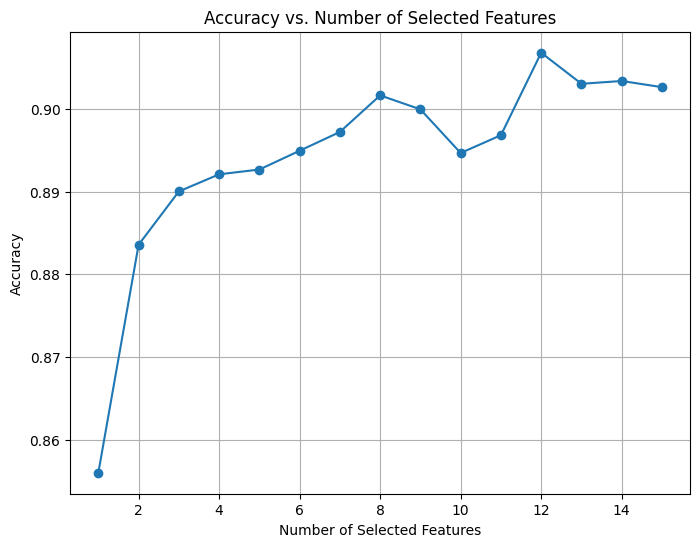

Optimal Threshold: 0.0110
Number of Selected Features: 12
Accuracy at Optimal Threshold: 0.0481


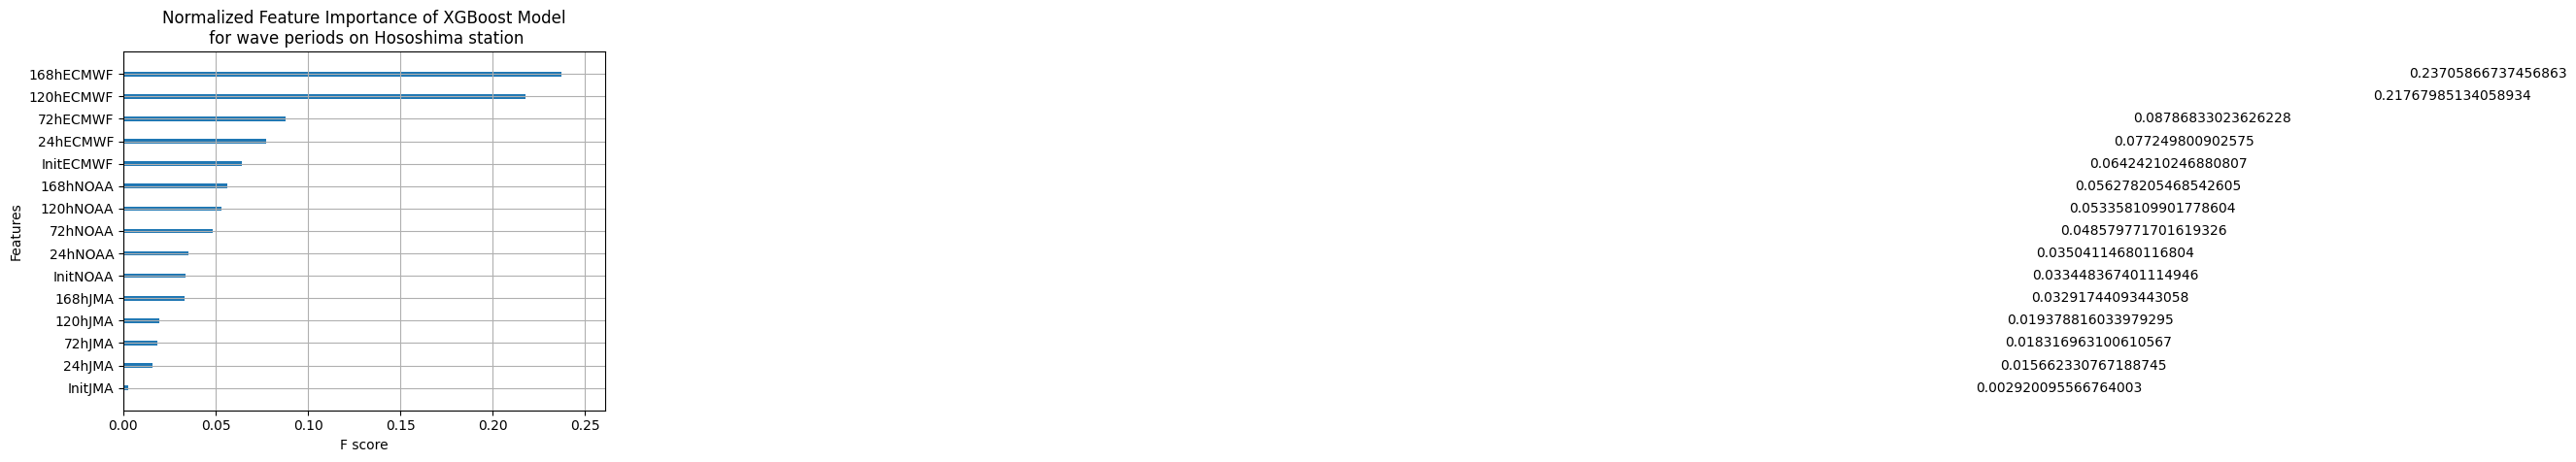

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr
from math import sqrt
# Train an XGBoost model
import xgboost as xgb
from xgboost import plot_importance
#model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model=xgb.XGBRegressor(learning_rate= 0.01, max_depth = 3, n_estimators=600,  random_state=42,eval_metric='rmse')
model.fit(X_train, y_train)
feature_name=X_train_original.columns
# Get the feature importance scores
importance_scores = model.feature_importances_

# Define a range of threshold values
thresholds = np.sort(model.feature_importances_)

# Initialize lists to store the results
num_features = []
accuracies = []
errors=[]

# Iterate over the threshold values
for threshold in thresholds:
    # Select features using the current threshold
    selector = SelectFromModel(model, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Train a new XGBoost model with the selected features
    selected_model = xgb.XGBRegressor(learning_rate= 0.01, max_depth = 3, n_estimators=600,  random_state=42, eval_metric='rmse')
    selected_model.fit(X_train_selected, y_train)

    # Evaluate the model on the test set
    y_pred = selected_model.predict(X_test_selected)
    accuracy, _ = pearsonr(y_pred, y_test)
    err=sqrt(mean_squared_error(y_test, y_pred))/(max(y_test)-min(y_test))
    # Store the number of selected features and accuracy
    num_features.append(X_train_selected.shape[1])
    accuracies.append(accuracy)
    errors.append(err)

    # Report progress
    print(f'> threshold={threshold}, features={X_train_selected.shape[1]}, accuracy={accuracy},nrmse={err}' )

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(num_features, accuracies, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Selected Features')
plt.grid(True)
plt.show()

# Find the optimal threshold
optimal_threshold_index = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_threshold_index]
optimal_num_features = num_features[optimal_threshold_index]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Number of Selected Features: {optimal_num_features}")
print(f"Accuracy at Optimal Threshold: {errors[optimal_threshold_index]:.4f}")
#feature_name
#model.set_attr(feature_names=",".join(feature_name))
#plot_importance(model, importance_type='weight')
#plt.yticks(range(len(feature_name)), feature_name) # Set custom y-axis labels
#plt.title('Feature Importance of XGBoost Model for wave heights on Onahama station')
#plt.show()
importance_dict = model.get_booster().get_score(importance_type="weight")

# Chuyển đổi thành danh sách (feature, importance)
features = list(importance_dict.keys())
f_scores = np.array(list(importance_dict.values()))

# Chuẩn hóa F-score về khoảng [0,1]
normalized_f_scores = f_scores / f_scores.sum()

# Tạo dictionary mới với giá trị đã chuẩn hóa
normalized_importance_dict = dict(zip(features, normalized_f_scores))
# Vẽ biểu đồ với giá trị chuẩn hóa
ax = xgb.plot_importance(normalized_importance_dict, importance_type="weight")
# Get the selected feature names
selected_feature_names = [feature_name[int(f[1:])] for f in features]
# Tùy chỉnh nhãn trục y theo danh sách feature
#model.set_attr(feature_names=",".join(feature_name))
plt.yticks(range(len(features)), selected_feature_names)  # Set custom y-axis labels

# Thêm tiêu đề
plt.title('Normalized Feature Importance of XGBoost Model\n for wave periods on Hososhima station')

# Hiển thị biểu đồ
#plt.figure(figsize=(10, 6))
plt.show()
